### 분석에 필요한 패키지 Import

In [ ]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
#!pip install xgboost lightgbm catboost scikit-learn --quiet

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [87]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [88]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [89]:
target = 'LeaveOrNot'

In [90]:
X = df.drop(target,axis=1,inplace=False) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [92]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [93]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [94]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [95]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [100]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [101]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [102]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [103]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [104]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [105]:
y_tree_pred = tree.predict(X_test)

In [106]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8359106529209622
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.74       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [107]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [108]:
y_svm_pred = svm.predict(X_test)

In [109]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



#### 4. kNN

In [110]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [111]:
y_knn_pred = knn.predict(X_test)

In [112]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.82      0.63      0.71       389

    accuracy                           0.83      1164
   macro avg       0.83      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



#### 네 가지 단일 모델의 결과 비교

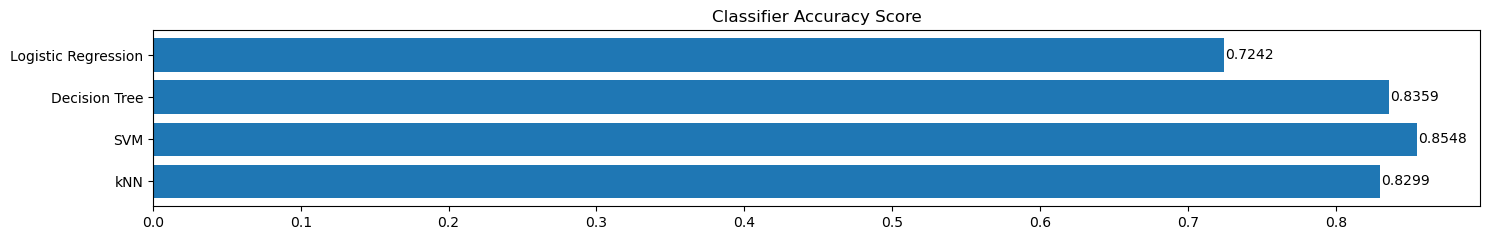

In [113]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [114]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [115]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting="hard"
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8505


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [116]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8540


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [117]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8239


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [118]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [119]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8608


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [120]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train,y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

Exception in thread Thread-85 (_readerthread):
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\anaconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb9 in position 24: invalid start byte
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^


LightGBM Accuracy: 0.8582


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [121]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train,y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8600


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [122]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=lr, # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8565


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

In [123]:
df = pd.read_csv("Employee.csv")

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [125]:
df.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain', 'LeaveOrNot'],
      dtype='object')

In [126]:
df["Education"].value_counts()

Education
Bachelors    3601
Masters       873
PHD           179
Name: count, dtype: int64

In [127]:
df["JoiningYear"].value_counts()

JoiningYear
2017    1108
2015     781
2014     699
2013     669
2016     525
2012     504
2018     367
Name: count, dtype: int64

In [128]:
df["City"].value_counts()

City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64

In [129]:
df["PaymentTier"].value_counts()

PaymentTier
3    3492
2     918
1     243
Name: count, dtype: int64

In [130]:
df["Age"].value_counts()

Age
26    645
28    630
27    625
25    418
24    385
29    230
30    220
37    141
36    139
34    136
38    136
40    134
32    132
39    131
31    125
33    124
35    123
41     82
22     49
23     48
Name: count, dtype: int64

In [131]:
df["Gender"].value_counts()

Gender
Male      2778
Female    1875
Name: count, dtype: int64

In [132]:
df["EverBenched"].value_counts()

EverBenched
No     4175
Yes     478
Name: count, dtype: int64

In [133]:
df["ExperienceInCurrentDomain"].value_counts()

ExperienceInCurrentDomain
2    1087
4     931
5     919
3     786
1     558
0     355
7       9
6       8
Name: count, dtype: int64

In [134]:
df["LeaveOrNot"].value_counts()

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

### 범주형 변수 처리

- 라벨 인코딩: 순서형 변수

In [135]:
edu_order = {'Bachelors': 0, 'Masters': 1, 'PHD': 2}
df['Education'] = df['Education'].map(edu_order)

In [136]:
gender_map = {'Male': 1, 'Female': 0}
df['Male'] = df['Gender'].map(gender_map)
df.drop("Gender",axis=1,inplace=True)

In [137]:
EverBenched_map = {'Yes': 1, 'No': 0}
df['EverBenched'] = df['EverBenched'].map(EverBenched_map)

In [138]:
# 5 이상을 모두 5로 변환
df['ExperienceInCurrentDomain'] = df['ExperienceInCurrentDomain'].apply(lambda x: min(x, 5))

In [139]:
tier_map = {3: 0, 2: 1, 1: 2}
df['Payment'] = df['PaymentTier'].map(tier_map)
df.drop("PaymentTier",axis=1,inplace=True)

In [140]:
df

,Education,JoiningYear,City,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Male,Payment
0,0,2017,Bangalore,34,0,0,0,1,0
1,0,2013,Pune,28,0,3,1,0,2
2,0,2014,New Delhi,38,0,2,0,0,0
3,1,2016,Bangalore,27,0,5,1,1,0
4,1,2017,Pune,24,1,2,1,1,0
...,...,...,...,...,...,...,...,...,...
4648,0,2013,Bangalore,26,0,4,0,0,0
4649,1,2013,Pune,37,0,2,1,1,1
4650,1,2018,New Delhi,27,0,5,1,1,0
4651,0,2012,Bangalore,30,1,2,0,1,0


<Axes: >

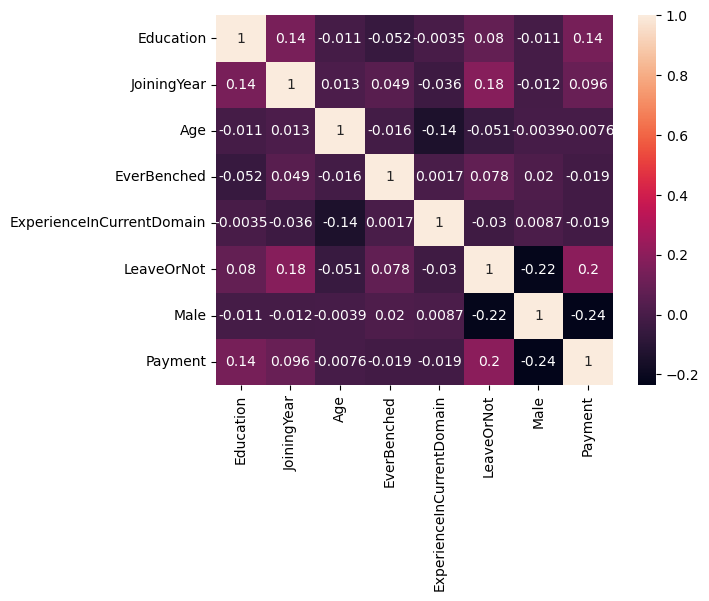

In [141]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

- 원핫인코딩

In [142]:
# 예시: 범주형 변수만 One-Hot 인코딩
df = pd.get_dummies(df, columns=['City'], drop_first=True, dtype = int)

In [143]:
df

,Education,JoiningYear,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Male,Payment,City_New Delhi,City_Pune
0,0,2017,34,0,0,0,1,0,0,0
1,0,2013,28,0,3,1,0,2,0,1
2,0,2014,38,0,2,0,0,0,1,0
3,1,2016,27,0,5,1,1,0,0,0
4,1,2017,24,1,2,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4648,0,2013,26,0,4,0,0,0,0,0
4649,1,2013,37,0,2,1,1,1,0,1
4650,1,2018,27,0,5,1,1,0,1,0
4651,0,2012,30,1,2,0,1,0,0,0


In [144]:
target = 'LeaveOrNot'

In [145]:
X = df.drop(target,axis=1,inplace=False) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 모델링 준비

In [146]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [147]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [148]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 9)
(3489,)
(1164, 9)
(1164,)


### 모델링

- XGBoost: 0.8719931271477663 -> 최종 ver. . .. 

In [200]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred)}")

XGBoost Accuracy: 0.8359106529209622


In [150]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_xgb_pred, digits=4))
print(confusion_matrix(y_test, y_xgb_pred))


              precision    recall  f1-score   support

           0     0.8651    0.9432    0.9025       775
           1     0.8621    0.7069    0.7768       389

    accuracy                         0.8643      1164
   macro avg     0.8636    0.8251    0.8397      1164
weighted avg     0.8641    0.8643    0.8605      1164

[[731  44]
 [114 275]]


In [151]:
# 클래스 불균형 비율
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED, scale_pos_weight=scale_pos_weight)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred)}")

XGBoost Accuracy: 0.8530927835051546


이게 최종임. . . 

In [152]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

# 파라미터 분포 정의 (넓은 범위)
param_dist = {
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 2),
    'learning_rate': uniform(0.05, 0.2),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'scale_pos_weight': [1.0]  # 불균형 직접 조절하지 않는 방향
}

# 모델 정의
xgb_model = xgb.XGBClassifier(
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)

# RandomizedSearchCV 설정
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # 샘플링 횟수
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1  # UnicodeEncodeError 방지용
)

# 학습
rand_search.fit(X_train, y_train)

# 최적 파라미터와 CV 정확도
print("Best Parameters:", rand_search.best_params_)
print("Best CV Accuracy:", rand_search.best_score_)

# 테스트셋 정확도
best_model = rand_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9248479063837987, 'gamma': 1.5451241658026418, 'learning_rate': 0.06537543516028013, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 256, 'scale_pos_weight': 1.0, 'subsample': 0.9324261070852198}
Best CV Accuracy: 0.8480940097449126
Test Accuracy: 0.8719931271477663


<Figure size 1000x600 with 0 Axes>

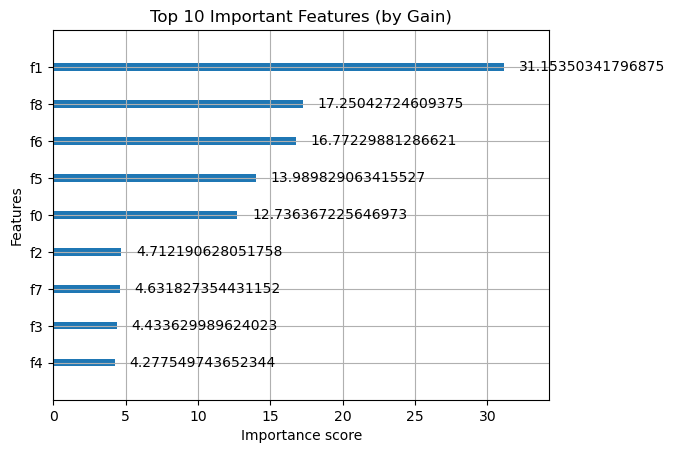

In [154]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# 중요도 시각화
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10, importance_type='gain')  # 상위 10개
plt.title("Top 10 Important Features (by Gain)")
plt.show()


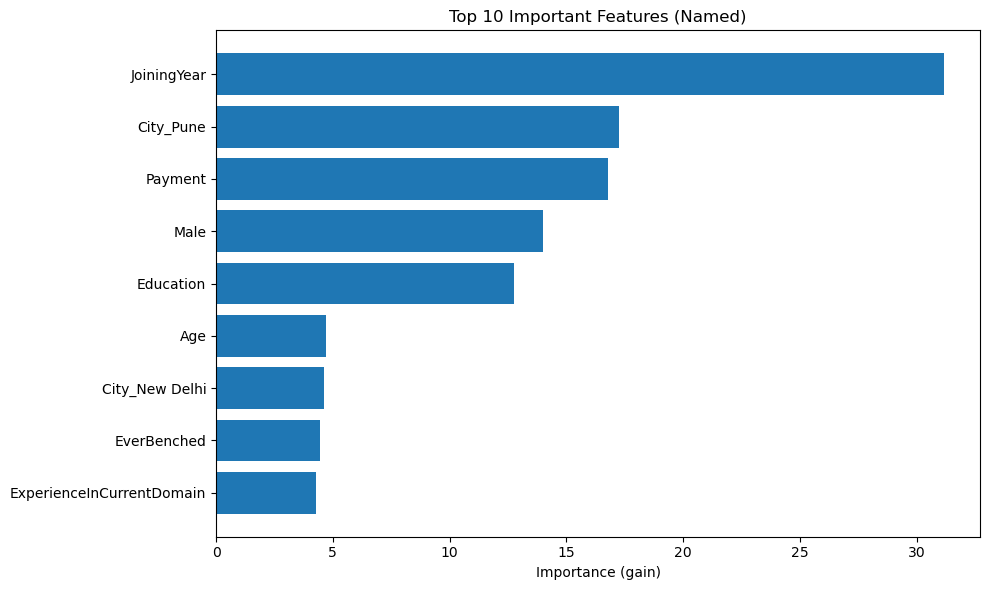

In [157]:
import matplotlib.pyplot as plt

# 1. feature 이름 목록 추출
feature_names = X.columns.tolist()  # X_train이 DataFrame일 경우

# 2. 중요도 (gain 기준) 추출
raw_importance = best_model.get_booster().get_score(importance_type='gain')

# 3. f0, f1, ...을 실제 컬럼명으로 매핑
named_importance = {
    feature_names[int(key[1:])]: value for key, value in raw_importance.items()
}

# 4. 정렬 및 시각화
sorted_importance = dict(sorted(named_importance.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_importance.keys())[:10][::-1], list(sorted_importance.values())[:10][::-1])
plt.xlabel("Importance (gain)")
plt.title("Top 10 Important Features (Named)")
plt.tight_layout()
plt.show()


### 새로운 모델... : XGBoost: 0.8805841924398625

- 근속연수 사용

In [81]:
X1 = X.copy()
X1['YearsAtCompany'] = 2018 - X1['JoiningYear']
X1.drop('JoiningYear',axis=1,inplace=True)

In [158]:
X1

,Education,Age,EverBenched,ExperienceInCurrentDomain,Male,Payment,City_New Delhi,City_Pune,YearsAtCompany
0,0,34,0,0,1,0,0,0,1
1,0,28,0,3,0,2,0,1,5
2,0,38,0,2,0,0,1,0,4
3,1,27,0,5,1,0,0,0,2
4,1,24,1,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
4648,0,26,0,4,0,0,0,0,5
4649,1,37,0,2,1,1,0,1,5
4650,1,27,0,5,1,0,1,0,0
4651,0,30,1,2,1,0,0,0,6


In [159]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

In [160]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [161]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

# 파라미터 분포 정의 (넓은 범위)
param_dist = {
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 2),
    'learning_rate': uniform(0.05, 0.2),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'scale_pos_weight': [1.0]  # 불균형 직접 조절하지 않는 방향
}

# 모델 정의
xgb_model = xgb.XGBClassifier(
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)

# RandomizedSearchCV 설정
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # 샘플링 횟수
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1  # UnicodeEncodeError 방지용
)

# 학습
rand_search.fit(X_train, y_train)

# 최적 파라미터와 CV 정확도
print("Best Parameters:", rand_search.best_params_)
print("Best CV Accuracy:", rand_search.best_score_)

# 테스트셋 정확도
best_model = rand_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8004879677423586, 'gamma': 1.8985862555469735, 'learning_rate': 0.23815565734736016, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 247, 'scale_pos_weight': 1.0, 'subsample': 0.8198911925369011}
Best CV Accuracy: 0.8501003152765835
Test Accuracy: 0.8805841924398625


### 새로운 모델... XGBoost: 0.8479381443298969 ㅠㅠ

In [170]:
df2 = df.copy()

- 나이 구간화

In [167]:
# 1. 나이별 전체 인원 수
all_by_age = df['Age'].value_counts().sort_index()

# 2. 나이별 이직자 수
left_by_age = df[df['LeaveOrNot'] == 1]['Age'].value_counts().sort_index()

# 3. 나이별 이직률
leave_rate_within_age = (left_by_age / all_by_age).sort_values(ascending=False)

leave_rate_within_age


Age
25    0.421053
32    0.409091
24    0.397403
22    0.387755
35    0.365854
27    0.361600
30    0.350000
26    0.345736
23    0.333333
29    0.326087
36    0.323741
33    0.322581
34    0.308824
40    0.305970
37    0.304965
39    0.297710
31    0.296000
28    0.295238
38    0.294118
41    0.280488
Name: count, dtype: float64

In [173]:
# 1. 이직률 기반 그룹화
df2['AgeGroup2'] = pd.cut(df2['Age'],
                         bins=[20, 23, 26, 30, 45],
                         labels=['20-23', '24-26', '27-30', '31+'])

# 2. High Risk Age 파생 변수 (이직률 높은 나이)
high_risk_ages = [22, 24, 25, 32]
df2['HighRiskAge'] = df2['Age'].isin(high_risk_ages).astype(int)

# 3. AgeGroup2 원핫 인코딩
agegroup2_encoded = pd.get_dummies(df2['AgeGroup2'], prefix='AgeGroup2')

# 4. 원본 데이터에 추가
df2 = pd.concat([df2, agegroup2_encoded], axis=1)

# 5. 타겟/피처 나누기
X2 = df2.drop(columns=['LeaveOrNot', 'AgeGroup2'])  # Age는 남겨둠
y = df2['LeaveOrNot']

X2['YearsAtCompany'] = 2018 - X2['JoiningYear']
X2.drop('JoiningYear',axis=1,inplace=True)

# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2)

# 6. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=SEED, stratify=y)

# 7. 모델 학습
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 8. 성능 출력
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc}")


✅ Test Accuracy: 0.8402061855670103


In [174]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 2),
    'learning_rate': uniform(0.05, 0.2),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'scale_pos_weight': [1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1  # Windows 인코딩 문제 방지
)

rand_search.fit(X_train, y_train)

print("Best Parameters:", rand_search.best_params_)
print("Best CV Accuracy:", rand_search.best_score_)

# 최종 테스트 정확도
best_model = rand_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7425041449788882, 'gamma': 0.74984897798464, 'learning_rate': 0.08427623966305572, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 253, 'scale_pos_weight': 1.0, 'subsample': 0.7821106484644265}
Best CV Accuracy: 0.8541129263399254
Test Accuracy: 0.8479381443298969


구간화 괜히 했군 .. . . . . 쳇